# 투자분석 hw4

20249433 최재필


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import yfinance as yf

## (a)

- MSFT
- GOOG
- KO

Source: Yahoo Finance

In [3]:
END = '2024-05-31'

# START = '2015-01-01'
START = pd.to_datetime(END) - pd.DateOffset(years=5)
START = START.strftime('%Y-%m-%d')


In [4]:
MSFT = yf.Ticker("MSFT") # originally MSFT
GOOG = yf.Ticker("GOOG") # originally GOOGL
KO = yf.Ticker("KO") # originally KO

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [5]:
MSFT_df = MSFT.history(start=START, end=END, interval='1mo')
MSFT_ret = MSFT_df['Close'].pct_change().dropna()
MSFT_ret = MSFT_ret.rename('MSFT')

GOOG_df = GOOG.history(start=START, end=END, interval='1mo')
GOOG_ret = GOOG_df['Close'].pct_change().dropna()
GOOG_ret = GOOG_ret.rename('GOOG')

KO_df = KO.history(start=START, end=END, interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(start=START, end=END, interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(start=START, end=END, interval='1mo')
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [6]:
MSFT_ret.index = MSFT_ret.index.to_period('M')
GOOG_ret.index = GOOG_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')
Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

Tbill3M_ret = Tbill3M_ret.reindex(MSFT_ret.index, method='ffill')

C:\Users\chlje\AppData\Local\Temp\ipykernel_59272\452896683.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MSFT_ret.index = MSFT_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_59272\452896683.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  GOOG_ret.index = GOOG_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_59272\452896683.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_59272\452896683.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index = SPY_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_59272\452896683.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Tbill3M_ret.index 

In [7]:
df = pd.concat([MSFT_ret, GOOG_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
df = df.dropna()

In [8]:
# Make it excess return
excs_df = df.loc[:, ['MSFT', 'GOOG', 'KO', 'SPY']].subtract(df.loc[:, 'Tbill3M'], axis=0)
excs_df.columns = [f'{ticker}_excs' for ticker in excs_df.columns]
excs_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2024-01,0.052958,0.001850,0.005180,0.015722
2024-02,0.036042,-0.018598,0.004557,0.047834
2024-03,0.014661,0.084947,0.014991,0.025167
2024-04,-0.078981,0.076937,0.013349,-0.041709
2024-05,0.061903,0.052243,0.014414,0.046215


## (b)

In [9]:
stocks = ['MSFT', 'GOOG', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

각 종목의 초과수익률을 시장 초과수익률에 대해 regress

In [10]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(excs_df[f'{stock}_excs'], excs_df['SPY_excs'], print_summary=True)
    print('\n'*5)

SIM regression result of MSFT
                            OLS Regression Results                            
Dep. Variable:              MSFT_excs   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     65.99
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           4.29e-11
Time:                        05:49:04   Log-Likelihood:                 102.64
No. Observations:                  59   AIC:                            -201.3
Df Residuals:                      57   BIC:                            -197.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108 

In [11]:
def get_result_values(single_stock_result):
    alpha, beta = single_stock_result.params
    t_value_alpha, t_value_beta = single_stock_result.tvalues
    p_value_alpha, p_value_beta = single_stock_result.pvalues
    r_squared = single_stock_result.rsquared

    # residual std는 따로 계산해야 함
    residuals = single_stock_result.resid
    resid_df = single_stock_result.df_resid
    residual_std = np.sqrt( (residuals**2).sum() / resid_df )

    result_values = {
        'alpha': alpha,
        'beta': beta,
        't_value_alpha': t_value_alpha,
        't_value_beta': t_value_beta,
        'p_value_alpha': p_value_alpha,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'residual_std': residual_std
    }

    return result_values


In [12]:
msft_result_values = get_result_values(results['MSFT'])
goog_result_values = get_result_values(results['GOOG'])
ko_result_values = get_result_values(results['KO'])


In [13]:
pd.DataFrame([msft_result_values, goog_result_values, ko_result_values], index=stocks)

,alpha,beta,t_value_alpha,t_value_beta,p_value_alpha,p_value_beta,r_squared,residual_std
MSFT,0.010755,0.863393,1.871315,8.123491,0.066437,4.287221e-11,0.536552,0.043222
GOOG,0.009623,1.055139,1.323007,7.844724,0.191116,1.245057e-10,0.519148,0.054698
KO,-0.000715,0.605450,-0.121253,5.551998,0.903917,7.693192e-07,0.350980,0.044348


## (c)

다음 방법을 파트 (C)에 사용할 예정입니다.

여기서의 문제는 시장 위험 프리미엄 $E[R_m]$, 그 표준 편차, 각 주식의 기대 수익률의 알파 $ \alpha_i $ 등의 예측된 값에 접근할 수 없다는 것입니다.

타임머신이 있다고 가정해보겠습니다. 우리가 2년 전으로 돌아갈 수 있다고 하면, 데이터가 2019년 8월부터 2024년 5월까지 (총 5년) 존재하므로 2022년 6월로 돌아가게 됩니다.

이 "미래" 2년치 데이터를 통해 시장 위험 프리미엄의 정확한 미래 값, 그 표준 편차, 각 주식의 기대 수익률의 알파를 추정할 수 있습니다.

이 데이터를 사용하여 최적의 위험 포트폴리오를 구성할 것입니다. 이 포트폴리오는 지수와 세 개의 주식으로 구성되며, 샤프 비율을 최대화하도록 설계될 것입니다.

In [14]:
lookahead = 24

In [15]:
# "미래" 2개년치와 "과거" 3개년치를 나눔

lookahead_excs_df = excs_df.iloc[-lookahead:, :].copy()
past_excs_df = excs_df.iloc[:-lookahead, :].copy()

In [16]:
# "미래" 기준으로 market excess return의 평균과 표준편차를 구함

mkt_excs_mean = lookahead_excs_df['SPY_excs'].mean() # Market expected return
mkt_excs_std = lookahead_excs_df['SPY_excs'].std() # Market expected volatility

In [17]:
ann_mkt_excs_mean = mkt_excs_mean * 12
ann_mkt_excs_std = mkt_excs_std * np.sqrt(12)

In [18]:
# "과거" 기준으로 beta를 구함

past_results = {}

for stock in stocks:
    past_results[stock] = get_SIM_regression(past_excs_df[f'{stock}_excs'], past_excs_df['SPY_excs'], print_summary=False)


In [19]:
# "과거" 기준 beta
betas = np.array([past_results[stock].params.iloc[1] for stock in stocks])
betas

array([0.86055334, 1.20528843, 0.70278247])

In [20]:
# "미래" 기준 excess return의 표준편차

msft_excs_std = lookahead_excs_df['MSFT_excs'].std()
goog_excs_std = lookahead_excs_df['GOOG_excs'].std()
ko_excs_std = lookahead_excs_df['KO_excs'].std()

excs_stds = np.array([msft_excs_std, goog_excs_std, ko_excs_std])
excs_stds

array([0.06712138, 0.07923446, 0.04195109])

In [21]:
ann_excs_stds = excs_stds * np.sqrt(12)
ann_excs_stds

array([0.23251527, 0.27447621, 0.14532284])

In [22]:
sys_stds = betas * ann_mkt_excs_std
sys_stds

array([0.16483649, 0.2308695 , 0.13461594])

In [23]:
resid_stds = np.sqrt(ann_excs_stds**2 - sys_stds**2)
resid_stds

array([0.16398866, 0.14844683, 0.05474738])

In [24]:
# "미래" 기준으로 alpha를 구함

lookahead_results = {}

for stock in stocks:
    lookahead_results[stock] = get_SIM_regression(lookahead_excs_df[f'{stock}_excs'], lookahead_excs_df['SPY_excs'], print_summary=False)

In [25]:
print(lookahead_results['GOOG'].summary())

                            OLS Regression Results                            
Dep. Variable:              GOOG_excs   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     11.94
Date:                Wed, 05 Jun 2024   Prob (F-statistic):            0.00225
Time:                        05:49:04   Log-Likelihood:                 32.508
No. Observations:                  24   AIC:                            -61.02
Df Residuals:                      22   BIC:                            -58.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.014      0.675      0.5

In [26]:
alphas = np.array([lookahead_results[stock].params.iloc[0] for stock in stocks])
alphas = alphas * 12 # annualize
alphas

array([ 0.10675492,  0.10936121, -0.06044151])

In [27]:
ANN_MKT_RISKPREMIUM = ann_mkt_excs_mean # "미래" 기준으로 구했던 market excess return

riskpremiums = ANN_MKT_RISKPREMIUM * betas
riskpremiums

array([0.09545658, 0.1336962 , 0.0779559 ])

In [48]:
ANN_MKT_RISKPREMIUM

0.11092465299057272

### 교수님 엑셀처럼 값 정리하여 optimal risky portfolio 구하기

#### $ \sigma^2(\epsilon_i) $ 

In [28]:
resid_vars = resid_stds**2
resid_vars

array([0.02689228, 0.02203646, 0.00299728])

#### $ \alpha_i / \sigma^2(\epsilon_i) $

In [29]:
alpha_div_resid_vars = alphas / resid_vars
alpha_div_resid_vars

array([  3.96972351,   4.96273883, -20.16548086])

#### $ w_i $

In [30]:
# weights = alpha_div_resid_vars / alpha_div_resid_vars.sum()
weights = alpha_div_resid_vars / np.abs(alpha_div_resid_vars).sum() # 부호 바뀌는 것 막기 위해 absolute sum으로 normalize
weights

array([ 0.13642626,  0.17055291, -0.69302083])

In [31]:
np.round(weights.sum(), 10)

-0.3860416679

#### $ \alpha_A $

In [32]:
weighted_alpha = weights @ alphas
weighted_alpha

0.07510327313781438

#### $ \beta_A $

In [33]:
weighted_beta = weights @ betas
weighted_beta

-0.164075371982428

#### $ \sigma^2(\epsilon_A) $ - residual variance

In [34]:
active_residual_var = weights**2 @ resid_vars
active_residual_var

0.002581050922577291

#### $ \sigma_A^2 $ - active portfolio variance


In [35]:
active_port_var = weighted_beta**2 * ann_mkt_excs_std**2 + active_residual_var
active_port_var

0.003568780243554076

#### $ w_A^0 $

In [36]:
w_A_0 = (weighted_alpha / active_residual_var) / (mkt_excs_mean / mkt_excs_std**2) # 여기서 lookahead std로 넣었다. 원래는 historical 쓰던데.
w_A_0

9.624659277846042

#### $ w_A^* $

In [37]:
w_A_star = w_A_0 / (1 + w_A_0 * (1 - weighted_beta))
w_A_star

0.7886589866719073

개별 주식 weight

In [38]:
final_weights = w_A_star * weights
final_weights

array([ 0.10759379,  0.13450808, -0.54655711])

#### $ w_M^* $

In [39]:
w_M_star = 1 - w_A_star
w_M_star

0.21134101332809274

### 그래프 확인

<Axes: xlabel='Date'>

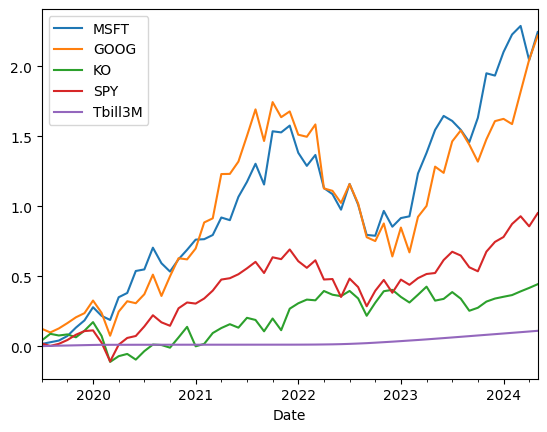

In [40]:
((1 + df).cumprod() - 1).plot()

In [41]:
final_alpha = final_weights @ alphas
final_alpha

0.059230871288612166

In [42]:
final_std = np.sqrt(final_weights @ resid_vars)
final_std

0.06495646458620014

## (d)

Information ratio

In [43]:
information_ratio = final_alpha / final_std
information_ratio

0.9118549118388386

## (e)

In [44]:
active_riskpremium = final_weights @ riskpremiums
active_riskpremium

-0.014353596476610497

In [45]:
optimal_riskpremium = ANN_MKT_RISKPREMIUM * w_M_star + active_riskpremium * w_A_star
optimal_riskpremium

0.012122835713753596

In [46]:
market_sharpe = ANN_MKT_RISKPREMIUM / ann_mkt_excs_std
market_sharpe

0.5790985843424171

In [47]:
optimal_sharpe = np.sqrt(market_sharpe ** 2 + information_ratio ** 2)
optimal_sharpe

1.0802011621138017